Plan:
- Data analysis:
    - Data visualization and exploration(means, medians etc.) + analyse result value distribution
    - Dealing with NaN values
    - Outlier detection and handling
- Feature Engineering (Feature selection):
    - Visualize correlation matrix in order to find least useful features that do not corelate with the output
    - Use other feature selection techniques
    - Perform a dimesion reduction:
        - Make a PCA plot
        - Try Heatmap, t-SNE plot, Multi-Dimensional Scaling(MDS)
- Data preparation:
    - Label encoding for categorical variables
    - Data normalization
    - Data splitting
- Selecting ML algorithm
- Regularization
- Hyperparameter tuning and use of cross-validation
- Testing

After looking at the data I have come to conclusion that the amount of features is big, so I decided to perform feature selection at first and then do some Feature engineering. Also the categorical variables seems not encoded and there are way too many categories in some features. There are also a lot of NaN values and I need to pick one of the methods to replace them.

## 0. Install dependencies

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt 


## 1. Load data

In [2]:
df = pd.read_csv("./train_df.csv", sep='\t')
print(df.head())

   Unnamed: 0   num_1   num_2  num_3   num_4   num_5   num_6  num_7  cat_1  \
0           0  1377.3  3712.9    NaN  1303.0  2409.0  1281.7   43.0      1   
1           1    20.0    13.4    NaN   565.0     NaN   357.2   19.0      1   
2           4   150.6     1.8    NaN  2294.0    15.0   107.6   76.0      1   
3           5    11.4   178.0    NaN  1236.0     NaN   350.6   41.0      1   
4           6  5372.0  3386.0    NaN  1340.0     NaN    14.0   45.0      1   

   num_8  ...  num_413  cat_132  cat_133      num_414  num_415  num_416  \
0  195.0  ...  11327.5        1        1  28162496.65      0.0     0.07   
1  170.0  ...    168.6        1        1    989383.82      0.0     0.56   
2  196.0  ...    209.1        1        1     87444.51      0.0     0.01   
3  117.0  ...     56.9        1        1    297608.00      0.0     0.08   
4    9.0  ...     31.0        1        1   6614247.89      0.0     0.20   

   cat_134  cat_135  id  gb  
0        1        1   1   0  
1        2        1 

In [3]:
repetitive_id = df['id'].duplicated()
print(len(df[repetitive_id==True]))

21581


As we can see the id may be repetitive and it means that one person may be present in dataframe various times. The id name may not be as important as the amout of its occurance in dataframe for the future model so we can create a new column that indicates how many times id was seen in the dataframe before. We won't use id column as the training data as well as the result (gb), so I will move these values to another dataframes

In [4]:
data = df.drop('gb',axis=1)
labels = df['gb']

In [22]:
print(str(len(labels)) + " 100%")
for value in labels.unique():
    print(str(labels[labels==value].count()) +" " + str((labels[labels==value].count()*100/len(labels))) +"%")


26824 100%
26231 97.78929317029525%
593 2.210706829704742%


The output value (target value) is very impalanced. There are several techniques to deal with this, later I will demonstrate 

## 2. Analyze Data

### 2.1 Data Exploration

First let's analyze categorical features. Maybe we would find a way to encode them or find hidden patterns.
<br>
<br>Extracting categorical features:

In [84]:
categorical = []
for column in df.columns:
    if column.find("cat")!=-1:
        categorical.append(column)
    df_categorical = df[categorical]
        

Descriptive Statistics

Max variance: 108034.93383735517
Min variance: 0.0001863724415168713
Max max-value: 1461
Min max-value: 2
Max min-value: 1
Min min-value: 1
Max mean: 384.58854011333136
Min mean: 1.0001864002385923
Max median: 316.0
Min median: 1.0


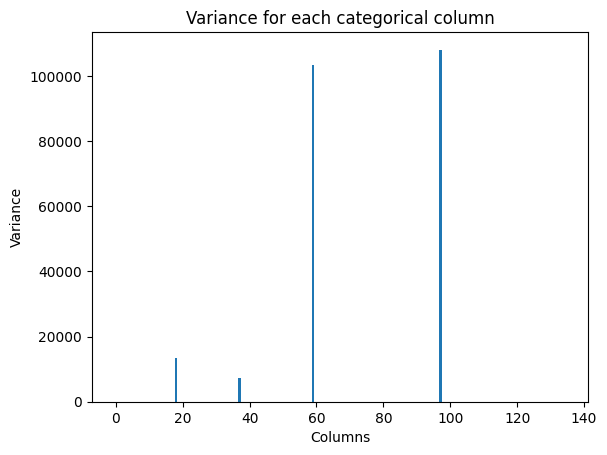

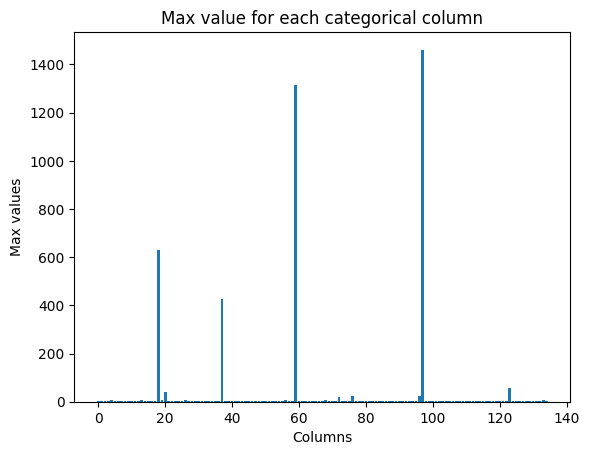

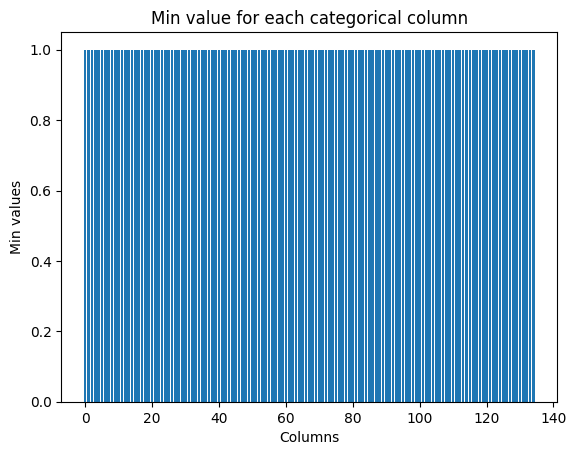

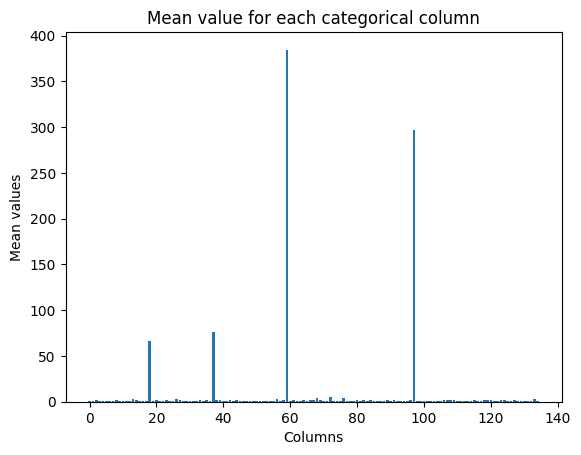

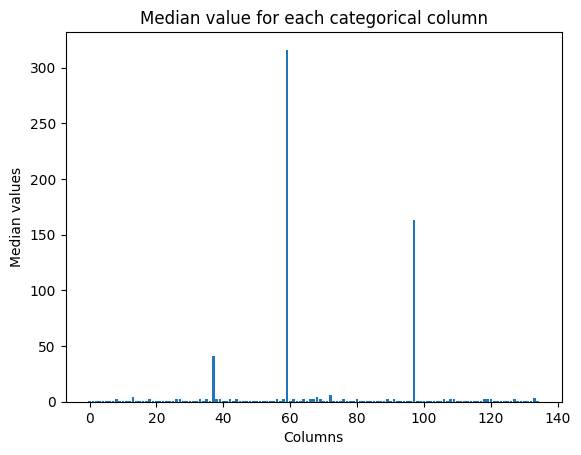

In [85]:
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each categorical column")
print("Max variance: " + str(max(df_categorical.var())))
print("Min variance: " + str(min(df_categorical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each categorical column")
print("Max max-value: " + str(max(df_categorical.max())))
print("Min max-value: " + str(min(df_categorical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each categorical column")
print("Max min-value: " + str(max(df_categorical.min())))
print("Min min-value: " + str(min(df_categorical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each categorical column")
print("Max mean: " + str(max(df_categorical.mean())))
print("Min mean: " + str(min(df_categorical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each categorical column")
print("Max median: " + str(max(df_categorical.median())))
print("Min median: " + str(min(df_categorical.median())))

plt.show()


In [86]:
print(df_categorical.median().median())

1.0


As we can see, the median of all medians is 1. <br>
Most of the categorical values equal to 1, avarage, median is near 1 and variance is around 0.